## KNOWLEDGE DISTILLATION
Just for completeness in this notebook we are going to show how to use various techniques of knowledge distillation, that are shonw in the bibliography's papers. All of these techniques are compatible with the method written during the work and I'm going to show how.

In [1]:
import tensorflow as tf
from WideResNet import WideResidualNetwork
from knowledge_distillation import *
from BANEnsemble import BANEnsemble
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np



In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 4s 0us/step


In [3]:
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

## Dataset check

It's a good idea to check if the dataset is balanced in order to know if accuracy can be a valid metric, so let's plot it. And in the next cells I'll build train, validation and test datasets, with a minimal image augmentation. Then I'll train the teacher on them as usual, nothing different from previous tests

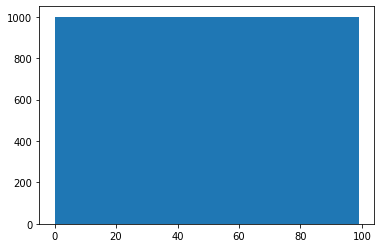

In [5]:
# Let's show an histogram in order to show if the test set is balanced and accuracy can be a valid metric
plt.hist(np.argmax(y_test, axis=1))
plt.show()

In [6]:

BATCH_SIZE = 32
N_CLASSES = 100
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
        )  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(x_train, y_train)
validation_generator = valid_datagen.flow(x_valid, y_valid)
test_generator = test_datagen.flow(x_test, y_test)

In [7]:
teacher_model = tf.keras.models.Sequential([
                                            WideResidualNetwork(N_CLASSES, 28, 1, includeActivation=False),
                                            tf.keras.layers.Activation('softmax')]
                                            )

In [10]:
teacher_callback = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = teacher_model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=[teacher_callback],
    validation_data=validation_generator
    
)

Epoch 1/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.9309 - accuracy: 0.4732 - val_loss: 2.3111 - val_accuracy: 0.4103
Epoch 2/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.8656 - accuracy: 0.4888 - val_loss: 2.3598 - val_accuracy: 0.4154
Epoch 3/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.8099 - accuracy: 0.5006 - val_loss: 2.3263 - val_accuracy: 0.4238
Epoch 4/100
1250/1250 [==============================] - 27s 21ms/step - loss: 1.7590 - accuracy: 0.5131 - val_loss: 2.0167 - val_accuracy: 0.4683
Epoch 5/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.7178 - accuracy: 0.5199 - val_loss: 2.0956 - val_accuracy: 0.4568
Epoch 6/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.6687 - accuracy: 0.5340 - val_loss: 1.9887 - val_accuracy: 0.4800
Epoch 7/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.6395 - accuracy: 0.5424 - val_loss: 2

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
teacher_model.save_weights('teacher_logits.h5')
teacher_model.evaluate(test_generator)

## Knowledge Distillation with logits
One possibility to distil knowledge is to use logits and try to match them, the loss function in this case is Mean Squared Error. The way is to remove the Activation layer from the teacher, then, the build_student function has to return a student without softmax and the compile_args dictionary should have the loss key set as "mse".

In [ ]:
teacher_logits = teacher_model.layers[0]
teacher_logits.compile(optimizer='adam', loss='mse')

In [ ]:
build_student = lambda : WideResidualNetwork(N_CLASSES, 28, 1, includeActivation=False)

In [ ]:
EPOCHS = 100
fit_args= dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)],
    steps_per_epoch=len(x_train)//BATCH_SIZE
)

compile_args=dict(
    optimizer='adam',
    loss='mse'
)

In [ ]:
history, students = ban(teacher_logits, 2, build_student, train_generator, fit_args=fit_args, compile_args=compile_args)

In [ ]:
complete_students = []

for student in students:
  complete_students.append(
      tf.keras.models.Sequential([
                                  student,
                                  tf.keras.layers.Activation('softmax')
      ])
  )

In [ ]:
for student in complete_students:
  student.compile(loss='categorical_crossentropy', metrics=['accuracy'])
  student.evaluate(test_generator)

313/313 [==============================] - 2s 5ms/step - loss: 1.8542 - accuracy: 0.5017


## Knowledge distillation with softened logits

This technique involves softening the softmax output using a temperature T, the idea is to use al Lambda layer after the logits and then pass the output to the softmax. Below there is the implementation

In [ ]:
soft_compile_args = dict(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
) 

In [ ]:
T = 3
EPOCHS = 150
fit_args= dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, monitor='loss', restore_best_weights=True)],
    steps_per_epoch=len(x_train)//BATCH_SIZE
)

softened_logits_teacher = tf.keras.Sequential(
    [
     teacher_logits,
     tf.keras.layers.Lambda(lambda x: x/T),
     tf.keras.layers.Activation('softmax')
    ]
)
build_softened_logits_student = lambda : tf.keras.models.Sequential(
    [
     WideResidualNetwork(N_CLASSES, 28, 1, includeActivation=False),
     tf.keras.layers.Lambda(lambda x: x/T),
     tf.keras.layers.Activation('softmax')
    ]
)
softened_logits_teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_soft, students_soft = ban(softened_logits_teacher, 2, build_softened_logits_student, train_generator, fit_args=fit_args, compile_args=soft_compile_args)

In [ ]:
unsoftened_students = [ tf.keras.models.Sequential(
    [student.layers[0],
     tf.keras.layers.Activation('softmax')]
) for student in students_soft]

for student in unsoftened_students:
  student.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  student.evaluate(test_generator)


## Knowledge distillation with ground truth
Another technique uses the ground truth to adjust the values to match, the method "ban" have a parameter called ground_truth_weight, where you can set the weight you want on ground truth, the paper suggests to use low values.

In [13]:
EPOCHS = 100
fit_args= dict(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, monitor='loss', restore_best_weights=True)],
    steps_per_epoch=len(x_train)//BATCH_SIZE
)

compile_gt_args = dict(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

build_student_with_gt = lambda : tf.keras.models.Sequential(
    [
     WideResidualNetwork(N_CLASSES, 28, 1, includeActivation=False),
     tf.keras.layers.Activation('softmax')
    ]
)


In [14]:
history_gt, students_gt = ban(teacher_model, 
                                  1, 
                                  build_student_with_gt, 
                                  train_generator, 
                                  fit_args=fit_args, 
                                  compile_args=compile_gt_args, 
                                  ground_truth_weight=1/N_CLASSES)

Training BAN-1
Epoch 1/100
1250/1250 [==============================] - 51s 41ms/step - loss: 3.9344 - accuracy: 0.1068
Epoch 2/100
1250/1250 [==============================] - 52s 42ms/step - loss: 3.2780 - accuracy: 0.2239
Epoch 3/100
1250/1250 [==============================] - 52s 41ms/step - loss: 2.8385 - accuracy: 0.3212
Epoch 4/100
1250/1250 [==============================] - 51s 41ms/step - loss: 2.5582 - accuracy: 0.3977
Epoch 5/100
1250/1250 [==============================] - 52s 41ms/step - loss: 2.3711 - accuracy: 0.4470
Epoch 6/100
1250/1250 [==============================] - 51s 41ms/step - loss: 2.2329 - accuracy: 0.4926
Epoch 7/100
1250/1250 [==============================] - 52s 41ms/step - loss: 2.1413 - accuracy: 0.5271
Epoch 8/100
1250/1250 [==============================] - 51s 41ms/step - loss: 2.0738 - accuracy: 0.5466
Epoch 9/100
1250/1250 [==============================] - 52s 41ms/step - loss: 2.0153 - accuracy: 0.5668
Epoch 10/100
1250/1250 [================

In [15]:
for student in students_gt:
  student.evaluate(test_generator)

313/313 [==============================] - 1s 5ms/step - loss: 1.6875 - accuracy: 0.5376


In [16]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

NameError: ignored